In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Load and Clean Data
fpl_data = pd.read_csv('man_utd_fpl_data.csv')

# Remove rows with missing critical data
columns_to_check = ['Goals_Scored', 'Goals_Conceded', 'Form', 'ICT_Index', 'Influence', 'Creativity', 'Threat', 'Minutes']
fpl_data = fpl_data.dropna(subset=columns_to_check)

# Ensure 'Minutes' is numeric and greater than 0
fpl_data['Minutes'] = pd.to_numeric(fpl_data['Minutes'], errors='coerce')
fpl_data = fpl_data[fpl_data['Minutes'] > 0]

# Step 2: Feature and Target Definition
features = ['Form', 'Influence', 'Creativity', 'Threat', 'Penalties', 'Minutes']
target_goals_scored = 'Goals_Scored'
target_goals_conceded = 'Goals_Conceded'

X = fpl_data[features]
y_goals_scored = fpl_data[target_goals_scored]
y_goals_conceded = fpl_data[target_goals_conceded]

# Step 3: Train-Test Split
X_train, X_test, y_train_goals, y_test_goals = train_test_split(X, y_goals_scored, test_size=0.2, random_state=42)
_, _, y_train_conceded, y_test_conceded = train_test_split(X, y_goals_conceded, test_size=0.2, random_state=42)

# Step 4: Data Imputation and Scaling
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

# Impute and scale training data
X_train_imputed = imputer.fit_transform(X_train)
X_train_scaled = scaler.fit_transform(X_train_imputed)

# Impute and scale testing data
X_test_imputed = imputer.transform(X_test)
X_test_scaled = scaler.transform(X_test_imputed)

# Step 5: Ridge Regression for Goals Scored
ridge_model_goals = Ridge(alpha=1.0)
ridge_model_goals.fit(X_train_scaled, y_train_goals)
predicted_goals = ridge_model_goals.predict(X_test_scaled)
rmse_goals = np.sqrt(mean_squared_error(y_test_goals, predicted_goals))
print(f"RMSE for Predicted Goals Scored: {rmse_goals:.2f}")

# Step 6: Ridge Regression for Goals Conceded
ridge_model_conceded = Ridge(alpha=1.0)
ridge_model_conceded.fit(X_train_scaled, y_train_conceded)
predicted_conceded = ridge_model_conceded.predict(X_test_scaled)
rmse_conceded = np.sqrt(mean_squared_error(y_test_conceded, predicted_conceded))
print(f"RMSE for Predicted Goals Conceded: {rmse_conceded:.2f}")

# Step 7: Predict Future Performance
fpl_data_imputed = imputer.transform(fpl_data[features])  # Impute missing values
fpl_data_scaled = scaler.transform(fpl_data_imputed)      # Scale the features

# Future predictions
future_goals = ridge_model_goals.predict(fpl_data_scaled)
future_conceded = ridge_model_conceded.predict(fpl_data_scaled)

# Add predictions to the DataFrame
fpl_data['Predicted_Future_Goals'] = future_goals
fpl_data['Predicted_Future_Conceded'] = future_conceded

# Step 8: Standardize and Normalize Predictions
fpl_data['Standardized_Goals_Scored'] = (fpl_data['Predicted_Future_Goals'] - fpl_data['Predicted_Future_Goals'].mean()) / fpl_data['Predicted_Future_Goals'].std()
fpl_data['Standardized_Goals_Conceded'] = (fpl_data['Predicted_Future_Conceded'] - fpl_data['Predicted_Future_Conceded'].mean()) / fpl_data['Predicted_Future_Conceded'].std()

fpl_data['Normalized_Goals_Scored'] = fpl_data['Standardized_Goals_Scored'] / fpl_data['Standardized_Goals_Scored'].max()
fpl_data['Normalized_Goals_Conceded'] = fpl_data['Standardized_Goals_Conceded'] / fpl_data['Standardized_Goals_Conceded'].max()

# Step 9: Filter Based on Position
fpl_data['Normalized_Goals_Scored'] = np.where(fpl_data['Position'] == 'Defender', np.nan, fpl_data['Normalized_Goals_Scored'])
fpl_data['Normalized_Goals_Conceded'] = np.where(fpl_data['Position'] == 'Forward', np.nan, fpl_data['Normalized_Goals_Conceded'])

# Step 10: Output Relevant Information
print(fpl_data[['Player', 'Position', 'Normalized_Goals_Scored', 'Normalized_Goals_Conceded']])

RMSE for Predicted Goals Scored: 0.19
RMSE for Predicted Goals Conceded: 2.19
         Player    Position  Normalized_Goals_Scored  \
0         Onana  Goalkeeper                -0.366154   
1   B.Fernandes  Midfielder                 0.754527   
2      Garnacho     Forward                 1.000000   
3         Dalot    Defender                      NaN   
4      Mazraoui    Defender                      NaN   
5       De Ligt    Defender                      NaN   
6      Rashford     Forward                 0.216039   
7      Martinez    Defender                      NaN   
8          Amad  Midfielder                 0.265079   
9      Casemiro  Midfielder                 0.237878   
10      Zirkzee     Forward                 0.323834   
11      Højlund     Forward                 0.176794   
12      Eriksen  Midfielder                -0.162663   
13        Evans    Defender                      NaN   
14       Mainoo  Midfielder                -0.302998   
15      Maguire    Defende

Recommended Attacker/Midfielder: Garnacho
Recommended Defender: Lindelof


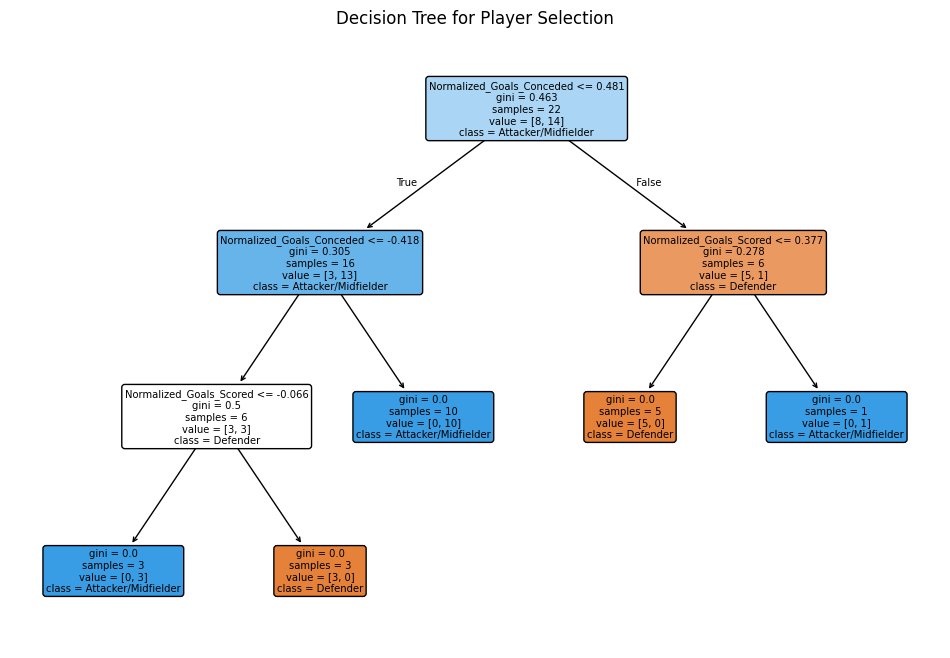

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Step 1: Sort Attackers/Midfielders by Scoring Probability
attack_mid = fpl_data[fpl_data['Position'].isin(['Midfielder', 'Forward'])]
attack_mid['Adjusted_Prob_Scoring'] = attack_mid['Normalized_Goals_Scored'] - (0.001 * attack_mid['Minutes'])
sorted_attack_mid = attack_mid.sort_values('Adjusted_Prob_Scoring', ascending=False)

# Step 2: Sort Defenders by Conceding Probability
defenders = fpl_data[fpl_data['Position'] == 'Defender']
defenders['Adjusted_Prob_Conceding'] = defenders['Normalized_Goals_Conceded'] + (0.001 * defenders['Minutes'])
sorted_defenders = defenders.sort_values('Adjusted_Prob_Conceding')

# Step 3: Select One Player
recommended_attacker = sorted_attack_mid.iloc[0]['Player']
recommended_defender = sorted_defenders.iloc[0]['Player']

print(f"Recommended Attacker/Midfielder: {recommended_attacker}")
print(f"Recommended Defender: {recommended_defender}")

# Step 4: Train a Simple Decision Tree for Visualization
# Add player names as features for better interpretation
fpl_data['Player_Name'] = fpl_data['Player']

# Prepare data for the tree
tree_features = ['Minutes', 'Normalized_Goals_Scored', 'Normalized_Goals_Conceded']
tree_target = fpl_data['Position'].apply(lambda x: 1 if x in ['Midfielder', 'Forward'] else 0)  # 1: Attacker/Midfielder, 0: Defender

tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(fpl_data[tree_features].fillna(0), tree_target)

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree_model, feature_names=tree_features, class_names=['Defender', 'Attacker/Midfielder'], filled=True, rounded=True)
plt.title("Decision Tree for Player Selection")
plt.show()

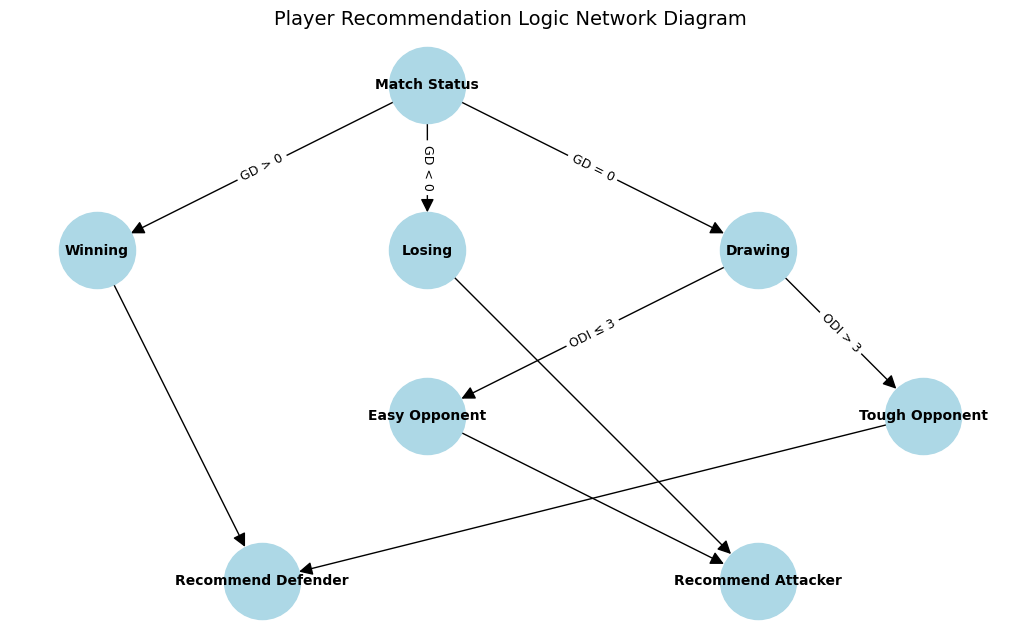

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph for the decision flow
G = nx.DiGraph()

# Add nodes and edges to represent the logic
G.add_edge("Match Status", "Winning", label="GD > 0")
G.add_edge("Match Status", "Losing", label="GD < 0")
G.add_edge("Match Status", "Drawing", label="GD = 0")
G.add_edge("Drawing", "Easy Opponent", label="ODI ≤ 3")
G.add_edge("Drawing", "Tough Opponent", label="ODI > 3")
G.add_edge("Winning", "Recommend Defender", label="")
G.add_edge("Losing", "Recommend Attacker", label="")
G.add_edge("Easy Opponent", "Recommend Attacker", label="")
G.add_edge("Tough Opponent", "Recommend Defender", label="")

# Define positions for the nodes to make the diagram clear
pos = {
    "Match Status": (0, 3),
    "Winning": (-2, 2),
    "Losing": (0, 2),
    "Drawing": (2, 2),
    "Easy Opponent": (0, 1),
    "Tough Opponent": (3, 1),
    "Recommend Defender": (-1, 0),
    "Recommend Attacker": (2, 0)
}

# Draw the network diagram
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", arrowsize=20)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)
plt.title("Player Recommendation Logic Network Diagram", fontsize=14)
plt.show()

In [ ]:
!pip install graphviz

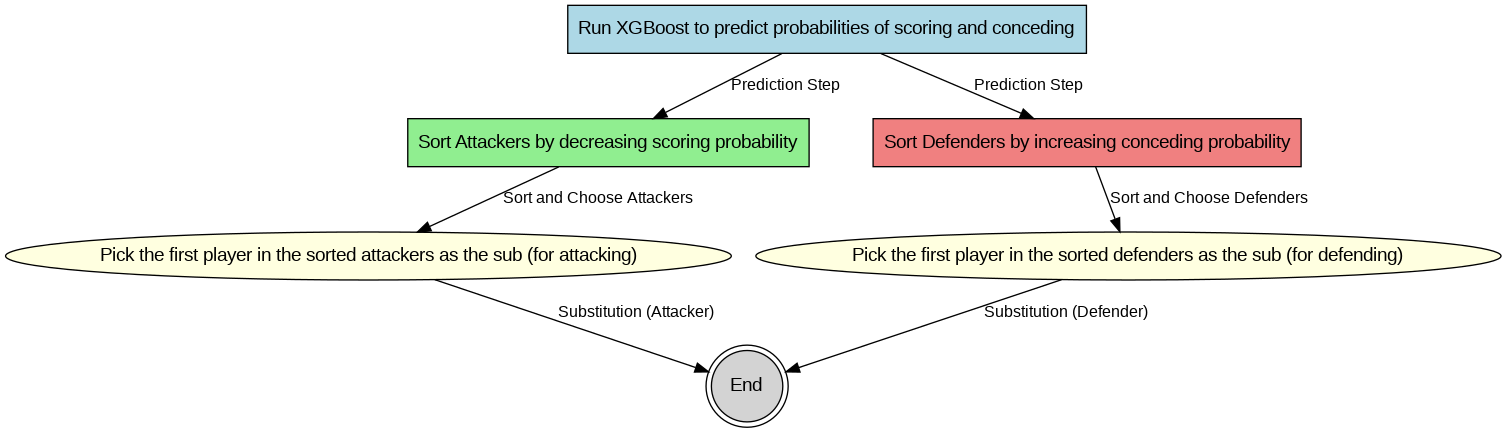

In [ ]:
from graphviz import Digraph

# Create a new directed graph
dot = Digraph(format='png', engine='dot')

# Add nodes with styling (color, shape, font, etc.)
dot.node('A', 'Run XGBoost to predict probabilities of scoring and conceding',
         shape='box', style='filled', fillcolor='lightblue', fontname='Helvetica', fontsize='14')
dot.node('B', 'Sort Attackers by decreasing scoring probability',
         shape='box', style='filled', fillcolor='lightgreen', fontname='Helvetica', fontsize='14')
dot.node('C', 'Sort Defenders by increasing conceding probability',
         shape='box', style='filled', fillcolor='lightcoral', fontname='Helvetica', fontsize='14')
dot.node('D', 'Pick the first player in the sorted attackers as the sub (for attacking)',
         shape='ellipse', style='filled', fillcolor='lightyellow', fontname='Helvetica', fontsize='14')
dot.node('E', 'Pick the first player in the sorted defenders as the sub (for defending)',
         shape='ellipse', style='filled', fillcolor='lightyellow', fontname='Helvetica', fontsize='14')
dot.node('F', 'End',
         shape='doublecircle', style='filled', fillcolor='lightgrey', fontname='Helvetica', fontsize='14')

# Add edges with styling (color, font, arrows)
dot.edge('A', 'B', label='Prediction Step', color='black', fontname='Helvetica', fontsize='12')
dot.edge('A', 'C', label='Prediction Step', color='black', fontname='Helvetica', fontsize='12')
dot.edge('B', 'D', label='Sort and Choose Attackers', color='black', fontname='Helvetica', fontsize='12')
dot.edge('C', 'E', label='Sort and Choose Defenders', color='black', fontname='Helvetica', fontsize='12')
dot.edge('D', 'F', label='Substitution (Attacker)', color='black', fontname='Helvetica', fontsize='12')
dot.edge('E', 'F', label='Substitution (Defender)', color='black', fontname='Helvetica', fontsize='12')

# Render the flowchart
dot.render('/content/player_sub_prescription_logic', view=True)

# Display the graph inline in the notebook
from IPython.display import Image
Image('/content/player_sub_prescription_logic.png')

Index(['Unnamed: 0', 'id_odsp', 'id_event', 'sort_order_subs', 'time_subs',
       'text_subs', 'event_type_subs', 'event_type2_subs', 'side_subs',
       'event_team_subs',
       ...
       'y_win', 'goal', 'sub_player_cluster_0', 'sub_player_cluster_1',
       'sub_player_cluster_2', 'sub_player_cluster_3', 'sub_player_0',
       'sub_player_1', 'sub_player_2', 'sub_player_3'],
      dtype='object', length=157)


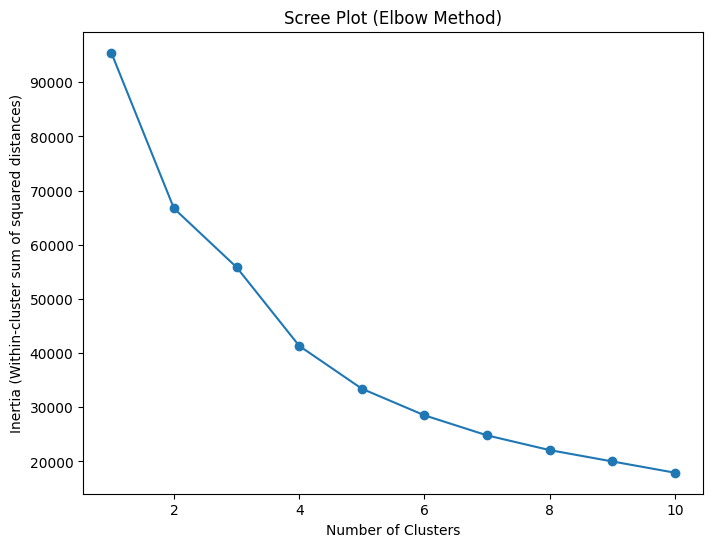

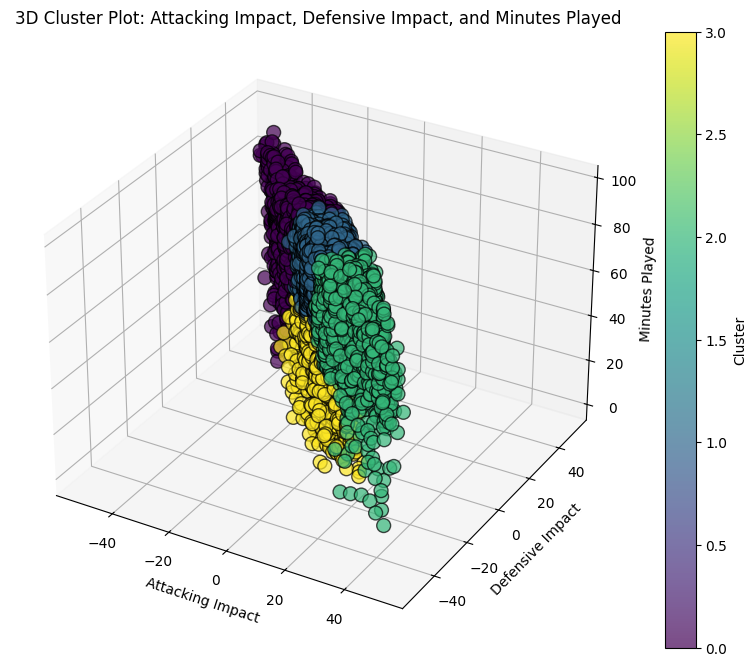

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

historical_data = pd.read_csv('Match Event Data.csv')

subratings = pd.read_csv('CompleteSubData.csv')

merged_data = pd.merge(
        historical_data,
        subsratings[['id_event', 'player_in', 'player_out', 'Rating',
                     'Preffered_Foot', 'Weak_foot', 'Skill_Moves',
                     'Ball_Control', 'Dribbling', 'Marking',
                     'Sliding_Tackle', 'Standing_Tackle', 'Aggression',
                     'Reactions', 'Attacking_Position', 'Interceptions',
                     'Vision', 'Composure', 'Crossing', 'Short_Pass',
                     'Long_Pass', 'Acceleration', 'Speed', 'Stamina',
                     'Strength', 'Balance', 'Agility', 'Jumping',
                     'Heading', 'Shot_Power', 'Finishing', 'Long_Shots',
                     'Curve', 'Freekick_Accuracy', 'Penalties', 'Volleys']],
        on='id_event', how='left', suffixes=('_historical', '_subsratings')
    )

print(merged_data.columns)

# Select clustering features (including 'minutes_played')
features = [
    'attacking_impact',
    'defensive_impact',
    'time_subs'  # Include minutes played for 3D plot
]

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(merged_data[features])

# Perform clustering
kmeans = KMeans(n_clusters=4, random_state=42)
merged_data['sub_cluster'] = kmeans.fit_predict(features_scaled)

# Inertia plot for elbow method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Scree Plot (Elbow Method)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-cluster sum of squared distances)')
plt.show()

# 3D Scatter Plot: Attacking Impact, Defensive Impact, and Minutes Played
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    merged_data['attacking_impact'],
    merged_data['defensive_impact'],
    merged_data['time_subs'],
    c=merged_data['sub_cluster'],  # Color by the cluster
    cmap='viridis',
    s=100, alpha=0.7, edgecolor='black'
)

# Set axis labels
ax.set_xlabel('Attacking Impact')
ax.set_ylabel('Defensive Impact')
ax.set_zlabel('Minutes Played')

# Add title
ax.set_title('3D Cluster Plot: Attacking Impact, Defensive Impact, and Minutes Played')

# Show color bar
fig.colorbar(scatter, label='Cluster')

# Show plot
plt.show()

In [ ]:
import plotly.express as px
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Assuming merged_data is already available and has the required columns
print(merged_data.columns)

# Select clustering features (including 'time_subs')
features = [
    'attacking_impact',
    'defensive_impact',
    'time_subs'  # Include minutes played for 3D plot
]

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(merged_data[features])

# Perform clustering
kmeans = KMeans(n_clusters=4, random_state=42)
merged_data['sub_cluster'] = kmeans.fit_predict(features_scaled)

# Create a 3D scatter plot using plotly
fig = px.scatter_3d(
    merged_data,
    x='attacking_impact',
    y='defensive_impact',
    z='time_subs',
    color='sub_cluster',
    title='3D Cluster Plot: Attacking Impact, Defensive Impact, and Time Subbed In',
    labels={'attacking_impact': 'Attacking Impact', 'defensive_impact': 'Defensive Impact', 'time_subs': 'Minutes Played'},
    color_continuous_scale='Viridis'
)

# Show the interactive plot
fig.show()

Index(['Unnamed: 0', 'id_odsp', 'id_event', 'sort_order_subs', 'time_subs',
       'text_subs', 'event_type_subs', 'event_type2_subs', 'side_subs',
       'event_team_subs',
       ...
       'shot_outcome_events', 'is_goal_events', 'location_events',
       'bodypart_events', 'assist_method_events', 'situation_events',
       'fast_break_events', 'attacking_impact', 'defensive_impact',
       'sub_cluster'],
      dtype='object', length=146)


In [ ]:
import plotly.express as px
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Assuming merged_data is already available and has the required columns
print(merged_data.columns)

# Select clustering features (including 'time_subs')
features = [
    'attacking_impact',
    'defensive_impact',
    'time_subs'# Include minutes played for 3D plot
]

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(merged_data[features])

# Perform clustering
kmeans = KMeans(n_clusters=4, random_state=42)
merged_data['sub_cluster'] = kmeans.fit_predict(features_scaled)

# Create a 3D scatter plot using plotly
fig = px.scatter_3d(
    merged_data,
    x='attacking_impact',
    y='defensive_impact',
    z='time_subs',
    color='sub_cluster',
    title='Clusters',
    labels={'attacking_impact': 'Attacking Impact', 'defensive_impact': 'Defensive Impact', 'time_subs': 'Time Subbed In'},
    color_continuous_scale='Viridis'
)

# Save the plot as an HTML file
fig.write_html('/content/3d_cluster_plot.html')

# Display the plot in a new tab (Colab/Notebook environment specific)
import webbrowser
webbrowser.open('/content/3d_cluster_plot.html')

Index(['Unnamed: 0', 'id_odsp', 'id_event', 'sort_order_subs', 'time_subs',
       'text_subs', 'event_type_subs', 'event_type2_subs', 'side_subs',
       'event_team_subs',
       ...
       'shot_outcome_events', 'is_goal_events', 'location_events',
       'bodypart_events', 'assist_method_events', 'situation_events',
       'fast_break_events', 'attacking_impact', 'defensive_impact',
       'sub_cluster'],
      dtype='object', length=146)


False

Decision Tree Accuracy: 0.9104477611940298


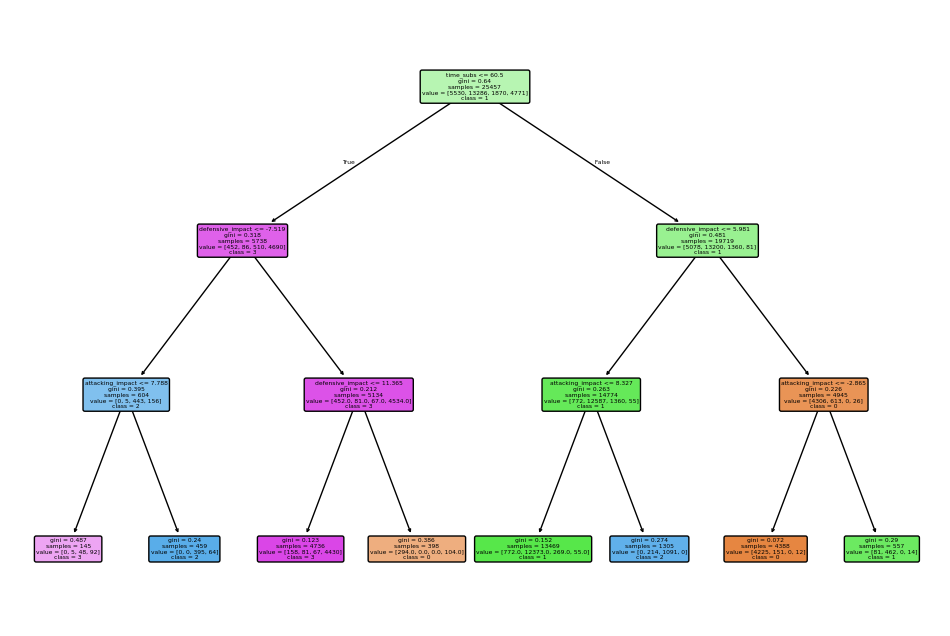

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assume merged_data has a column 'sub_cluster' for the cluster labels (target variable)
X = merged_data[['attacking_impact', 'defensive_impact', 'time_subs']]  # Add more features if needed
y = merged_data['sub_cluster']  # Cluster labels as the target variable

import pandas as pd

# Save X to a CSV file
X.to_csv('features_X.csv', index=False)

# Save y to a CSV file
y.to_csv('target_y.csv', index=False)


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree Classifier
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

# Predict the cluster labels on the test set
y_pred = tree_model.predict(X_test)

# Evaluate the model (Accuracy)
accuracy = tree_model.score(X_test, y_test)
print(f"Decision Tree Accuracy: {accuracy}")

# Plot the tree to interpret the features contributing to clusters
plt.figure(figsize=(12, 8))
plot_tree(tree_model, filled=True, feature_names=X.columns, class_names=[str(i) for i in tree_model.classes_], rounded=True)
plt.show()

In [ ]:
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
import webbrowser

# Assume merged_data has a column 'sub_cluster' for the cluster labels (target variable)
X = merged_data[['attacking_impact', 'defensive_impact', 'time_subs', 'side_subs']]  # Add more features if needed
y = merged_data['sub_cluster']  # Cluster labels as the target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree Classifier
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

# Predict the cluster labels on the test set
y_pred = tree_model.predict(X_test)

# Evaluate the model (Accuracy)
accuracy = tree_model.score(X_test, y_test)
print(f"Decision Tree Accuracy: {accuracy}")

# Export the tree to DOT format (Graphviz)
dot_data = export_graphviz(
    tree_model,
    out_file=None,
    feature_names=X.columns,
    class_names=[str(i) for i in tree_model.classes_],
    filled=True,
    rounded=True,
    special_characters=True
)

# Create a Graphviz source object
graph = graphviz.Source(dot_data)

# Save the graph to PNG format
graph.render('decision_tree', format='png')

# Open the saved PNG file in a new browser tab
webbrowser.open('decision_tree.png')

Decision Tree Accuracy: 0.9104477611940298


False

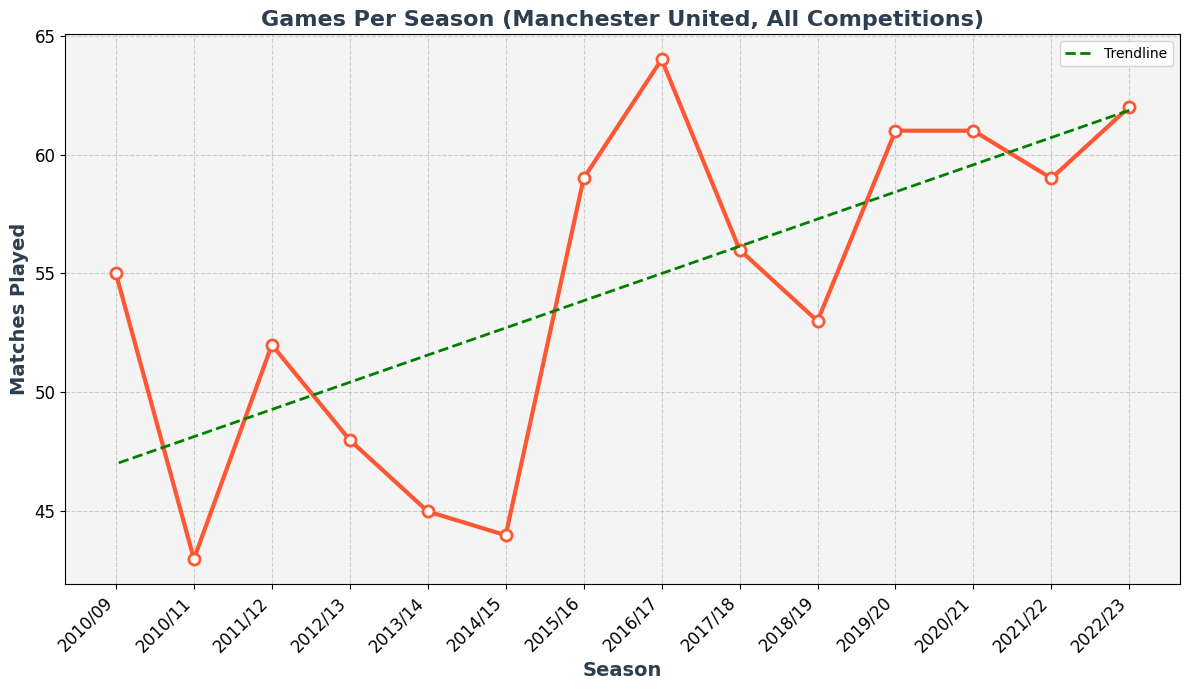

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for matches played each season, excluding 2023/24
seasons = ['2022/23', '2021/22', '2020/21', '2019/20', '2018/19', '2017/18', '2016/17', '2015/16', '2014/15', '2013/14', '2012/13', '2011/12', '2010/11', '2010/09']
matches_played = [62, 59, 61, 61, 53, 56, 64, 59, 44, 45, 48, 52, 43, 55]

# Convert season labels to numeric values for fitting the trendline
season_numbers = np.arange(len(seasons))

# Create the plot with a larger figure and a style
plt.figure(figsize=(12, 7))
plt.plot(seasons, matches_played, marker='o', color='#FF5733', linestyle='-', linewidth=3, markersize=8, markerfacecolor='white', markeredgewidth=2)

# Fit a linear trendline
z = np.polyfit(season_numbers, matches_played, 1)  # Fit a linear polynomial (degree 1)
p = np.poly1d(z)  # Create a polynomial function
plt.plot(seasons, p(season_numbers), color='green', linestyle='--', linewidth=2, label="Trendline")

# Flip the x-axis
plt.gca().invert_xaxis()

# Customize grid, background, and labels
plt.gca().set_facecolor('#f4f4f4')  # Change the background color
plt.grid(True, linestyle='--', alpha=0.6)  # Make the grid dotted and a bit transparent
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)

# Add title and labels with more emphasis on style
plt.title("Games Per Season (Manchester United, All Competitions)", fontsize=16, weight='bold', color='#2C3E50')
plt.xlabel("Season", fontsize=14, weight='bold', color='#2C3E50')
plt.ylabel("Matches Played", fontsize=14, weight='bold', color='#2C3E50')

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()